In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale, minmax_scale
from sklearn import metrics

%matplotlib inline

# hockey = pd.read_pickle('/Users/marc/ds/metis/metisgh/hockey_filtered.csv') # Excluding NaNs
# hockey = pd.read_pickle('/Users/marc/ds/metis/metisgh/hockey.csv') # All cleaned data INCL. NANs

In [107]:
hockey.birthCountry.replace('USSR','Russia',True)
hockey.rename(index=str, columns={'shootCatch': 'shoot'},inplace=True)

### 2013-2014 Players (for Eligibility)

In [3]:
Recent = pd.read_csv('NHLPlayers2013-14.csv')
allrecent = hockey[hockey.name.isin(Recent.Names)]
allrecent = allrecent[['playerID']]
allrecent['recent'] = 1
hockey = pd.merge(hockey,allrecent,how='outer')
hockey.recent.fillna(0,inplace=True)

NameError: name 'hockey' is not defined

### New HOF inductees since 2011 -- Holdout 

In [109]:
HOF2 = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/HOF2.csv')
HOF2 = HOF2[HOF2.Year > 2011] ## Rogie Vachon & Dominik Hasek = Goalies
HOF2_names = HOF2.Name

In [110]:
new_HOF = hockey[hockey.name.isin(HOF2_names)].copy()
new_HOF['new_HOF'] = 1

hockey = pd.merge(hockey,new_HOF,how='outer')
hockey.new_HOF.fillna(0,inplace=True)

## HOF-Eligible Players

In [111]:
HOFtable = pd.read_csv('/Users/marc/ds/metis/metisgh/hockey/HOF.csv')
HOFtable['playerID'] = [x[:-1] for x in HOFtable['hofID']]
HOFtable = HOFtable[HOFtable.category=='Player']
HOFtable = HOFtable[['playerID','year']]
HOFtable.columns = ['playerID','HOFyear']
HOFdelay = pd.merge(hockey[hockey.HOF==1],HOFtable,how='inner')

In [112]:
years = HOFdelay[['name','LastYear','HOFyear']].copy()
years['Delay'] = HOFdelay.HOFyear - HOFdelay.LastYear
years.sort_values('Delay',ascending=False).head(10);

In [113]:
all_retired = hockey[(hockey.recent == 0) & (hockey.new_HOF == 0)]
all_recent = hockey[(hockey.recent == 1) & (hockey.new_HOF == 0)] ## not needed

# cutoff = 2017-20
# elig = hockey[(hockey.HOF == 0) & (hockey.recent == 0) & (hockey.LastYear >= cutoff)]

In [114]:
ret_nHOF = all_retired.HOF.value_counts()[0] # Retired Non-HOF
print('Retired Non-HOF Count:',ret_nHOF)
ret_HOF = all_retired.HOF.value_counts()[1] # Retired HOF
print('Retired \HOF Count:',ret_HOF)

# Baseline accuracy
noHOF_pred = ret_nHOF/(ret_HOF+ret_nHOF)
noHOF_pred

Retired Non-HOF Count: 5719
Retired \HOF Count: 182


0.96915776986951363

# Classifiers

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Define y, X and holdout y & X

In [116]:
y = all_retired.HOF
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
subset = ['HOF','recent','new_HOF','logGP','logCareer_Years']
X = all_retired.select_dtypes(include=numerics).drop(subset,axis=1)

holdout_y = new_HOF.new_HOF
holdout_X = new_HOF.select_dtypes(include=numerics).drop(subset,axis=1)

In [117]:
# Replace missing values with mean
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0,copy=False)
newX = imp.fit_transform(X);
X = pd.DataFrame(newX,columns=X.columns)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=321,stratify=y)

In [119]:
Xtr = pd.DataFrame(X_train)
Xte = pd.DataFrame(X_test)
ytr = pd.DataFrame(y_train)
yte = pd.DataFrame(y_test)

In [120]:
ytr.HOF.value_counts()

0    4003
1     127
Name: HOF, dtype: int64

In [121]:
yte.HOF.value_counts()

0    1716
1      55
Name: HOF, dtype: int64

In [122]:
holdout_text = new_HOF[['name','shoot','birthCountry']]

# #1. Classifiers -- Train/Test Split

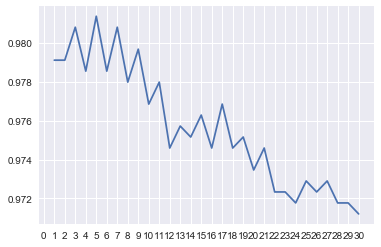

Best K: 5


In [123]:
# K-Nearest Neighbors
knn_scores = {}
for k in range(1,31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    knn_scores[k] = metrics.accuracy_score(y_test, y_pred)
    
plt.plot(list(knn_scores.keys()),list(knn_scores.values()))
plt.xticks(np.arange(0, 31, 1.0))
plt.show()

highest_k = max(knn_scores, key=knn_scores.get)
print('Best K:', highest_k)

In [124]:
## Define classifiers 
knn = KNeighborsClassifier(n_neighbors=highest_k)
logreg = LogisticRegression()
gauss = GaussianNB()
svc = SVC(probability=True)#,kernel='linear')
# lsvc = LinearSVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

classifiers = [knn,logreg,gauss,svc,dtc,rfc]
classifiernames = ['KNN','LogReg','Gauss','SVM','DTC','RFC']

KNN 
Train/Test Classification Report:
 ---------------------------------------------------
              precision    recall  f1-score   support

          0       0.98      1.00      0.99      1716
          1       0.82      0.51      0.63        55

avg / total       0.98      0.98      0.98      1771

KNN 
Holdout Classification Report:
 ---------------------------------------------------
              precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.43      0.60        21

avg / total       1.00      0.43      0.60        21

LogReg 
Train/Test Classification Report:
 ---------------------------------------------------
              precision    recall  f1-score   support

          0       0.99      0.99      0.99      1716
          1       0.75      0.76      0.76        55

avg / total       0.98      0.98      0.98      1771

LogReg 
Holdout Classification Report:
 ------------------------------------

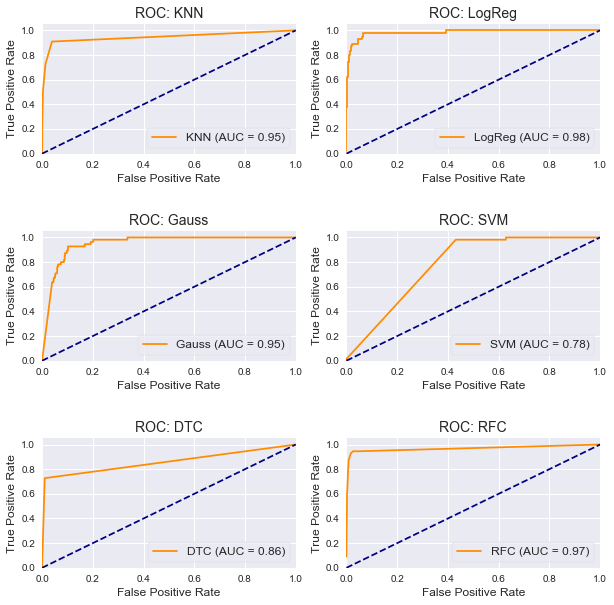

In [125]:
scores = {}
holdoutscores = {}
holdoutpreds = {}
fpr = {}
tpr = {}
roc_auc = {}

for clf, clfname in zip(classifiers,classifiernames):
# Fit Model to Training Data
    model = clf.fit(X_train,y_train)
    
# Predictions from Test 
    y_pred = model.predict(X_test) 
    
# Calculate and Store Metrics for Train/Test
    acc = metrics.accuracy_score(y_test,y_pred)
    prec = metrics.precision_score(y_test,y_pred)
    rec = metrics.recall_score(y_test,y_pred)
    F1 = metrics.f1_score(y_test,y_pred)
    scores[clfname] = [acc,prec,rec,F1]
    
# Calculate Test Score for ROC/AUC
    try:
        y_score = model.decision_function(X_test)
    except AttributeError:
        y_score = model.predict_proba(X_test)[:,1:]
    
    fpr[clfname],tpr[clfname], _ = metrics.roc_curve(y_test,y_score)
    roc_auc[clfname] = metrics.auc(fpr[clfname],tpr[clfname])

#################
## HOLDOUT SET ##
#################

# Predictions from Holdout Set
    y_pred2 = model.predict(holdout_X)
    
# Create Holdout Dataframe
    holdout = holdout_text.copy()
    
# Calculate and Store Metrics for Holdout Set
    acc2 = metrics.accuracy_score(holdout_y,y_pred2)
    prec2 = metrics.precision_score(holdout_y,y_pred2)
    rec2 = metrics.recall_score(holdout_y,y_pred2)
    F12 = metrics.f1_score(holdout_y,y_pred2)   
    holdoutscores[clfname] = [acc2,prec2,rec2,F12]

# Calculate Probabilities for Each Holdout Prediction
    holdout['Prediction'] = y_pred2
    
    try:
        y_prob = model.predict_proba(holdout_X)
        holdout['Probability'] = y_prob[:,1]
    except AttributeError:
        y_prob = np.nan
        holdout['Probability'] = y_prob   
    
# Save Probabilities and Predictions to Dictionary
    holdoutpreds[clfname] = holdout
    
## Classification Reports
    print(clfname,'\nTrain/Test Classification Report:\n',
    '---------------------------------------------------\n',
    metrics.classification_report(y_test, y_pred))   

    print(clfname,'\nHoldout Classification Report:\n',
    '---------------------------------------------------\n',
    metrics.classification_report(holdout_y, y_pred2))
    
summary = pd.DataFrame(scores)
summary.insert(0,'Metric',['Accuracy','Precision','Recall','F1 Score'])

holdout_summary = pd.DataFrame(holdoutscores)
holdout_summary.insert(0,'Metric',['Accuracy','Precision','Recall','F1 Score'])

print('Train/Test Classification Metrics\n',
      '---------------------------------------------------')
print(summary.round(2),
      '\n---------------------------------------------------\n')
print('Holdout Classification Metrics\n',
      '---------------------------------------------------')
print(holdout_summary.round(2),
      '\n---------------------------------------------------\n')

for clfname, preds in holdoutpreds.items():
    print(clfname,
          'Predictions:\n',
          '------------------------------------------------------------------------\n',
          preds,'\n')

#ROC_AUC
plt.figure(figsize=(10,10))
for n,c in enumerate(classifiernames):
    plt.subplot(3,2,n+1)
    plt.subplots_adjust(hspace=0.6)
    plt.title('ROC: '+c,fontsize=14)
    
    plt.plot(fpr[c],tpr[c],color='darkorange',label = c+' (AUC = %0.2f)' %roc_auc[c])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.legend(loc='lower right',frameon=True,fontsize=12)

# #2 Cross-Validation

In [126]:
from sklearn.cross_validation import cross_val_score

knn_score = np.mean(cross_val_score(knn,X,y,cv=5,scoring='accuracy',n_jobs=-1))
logreg_score = np.mean(cross_val_score(logreg,X,y,cv=5,scoring='accuracy',n_jobs=-1))
gauss_score = np.mean(cross_val_score(gauss,X,y,cv=5,scoring='accuracy',n_jobs=-1))
svc_score = np.mean(cross_val_score(svc,X,y,cv=5,scoring='accuracy',n_jobs=-1))
# lsvc_score = np.mean(cross_val_score(lsvc,X,y,cv=5,scoring='accuracy',n_jobs=-1))
dtc_score = np.mean(cross_val_score(dtc,X,y,cv=5,scoring='accuracy',n_jobs=-1))
rfc_score = np.mean(cross_val_score(rfc,X,y,cv=5,scoring='accuracy',n_jobs=-1))

results = pd.DataFrame([knn_score,logreg_score,gauss_score,svc_score,dtc_score,rfc_score],columns=['Score'])
results['Classifier'] = ['KNN','LogReg','Gauss','SVM','DTC','RFC']
results['vs. Baseline'] = results.Score - noHOF_pred
results = results[['Classifier','Score','vs. Baseline']]
results

,Classifier,Score,vs. Baseline
0,KNN,0.979156,9.997780e-03
1,LogReg,0.983561,1.440327e-02
2,Gauss,0.907127,-6.203098e-02
3,SVM,0.969158,2.173191e-07
4,DTC,0.980680,1.152263e-02
5,RFC,0.984918,1.576049e-02


# ... Normalize and Upsample Data

In [127]:
from sklearn.preprocessing import normalize
from imblearn.over_sampling import SMOTE

X_norm = pd.DataFrame(normalize(X, axis=0,norm='l1'),columns=X.columns)
holdout_X = pd.DataFrame(normalize(holdout_X, axis=0,norm='l1'),columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.30,random_state=321,stratify=y)

sm = SMOTE(ratio = 1.0,random_state=1189)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

X_train = pd.DataFrame(x_train_res,columns=X.columns)
y_train = y_train_res

train = pd.concat([X_train.reset_index(), pd.DataFrame(y_train,columns=['HOF']).reset_index()],axis=1)
test = pd.concat([X_test.reset_index(), pd.DataFrame(y_test,columns=['HOF']).reset_index()],axis=1)
upsampled = pd.concat([train,test],axis=0)
upsampled.drop('index',axis=1);

In [128]:
Xtr = pd.DataFrame(X_train)
Xte = pd.DataFrame(X_test)
ytr = pd.DataFrame(y_train)
ytr.columns = ['HOF']
yte = pd.DataFrame(y_test)
yte.columns = ['HOF']

In [129]:
ytr.HOF.value_counts()

1    4003
0    4003
Name: HOF, dtype: int64

In [130]:
yte.HOF.value_counts()

0    1716
1      55
Name: HOF, dtype: int64

In [131]:
# Upsampled X & y
X = upsampled.iloc[:,:-1].drop('index',axis=1)
y = upsampled.iloc[:,-1]

In [132]:
upsampled.HOF.value_counts()

0    5719
1    4058
Name: HOF, dtype: int64

# #3 Upsampled Train/Test Split

Train/Test Classification Metrics
 ---------------------------------------------------
      Metric   DTC  Gauss   KNN  LogReg   RFC   SVM
0   Accuracy  0.97   0.89  0.96    0.97  0.98  0.97
1  Precision  0.53   0.21  0.42    0.50  0.68  1.00
2     Recall  0.64   0.89  0.82    0.67  0.71  0.02
3   F1 Score  0.58   0.34  0.56    0.57  0.70  0.04 
---------------------------------------------------

Holdout Classification Metrics
 ---------------------------------------------------
      Metric   DTC  Gauss  KNN  LogReg  RFC  SVM
0   Accuracy  0.05    1.0  1.0     1.0  0.0  1.0
1  Precision  1.00    1.0  1.0     1.0  0.0  1.0
2     Recall  0.05    1.0  1.0     1.0  0.0  1.0
3   F1 Score  0.09    1.0  1.0     1.0  0.0  1.0 
---------------------------------------------------

KNN Predictions:
 ------------------------------------------------------------------------
                    name shoot birthCountry  Prediction  Probability
116       Teemu Selanne     R      Finland           1  

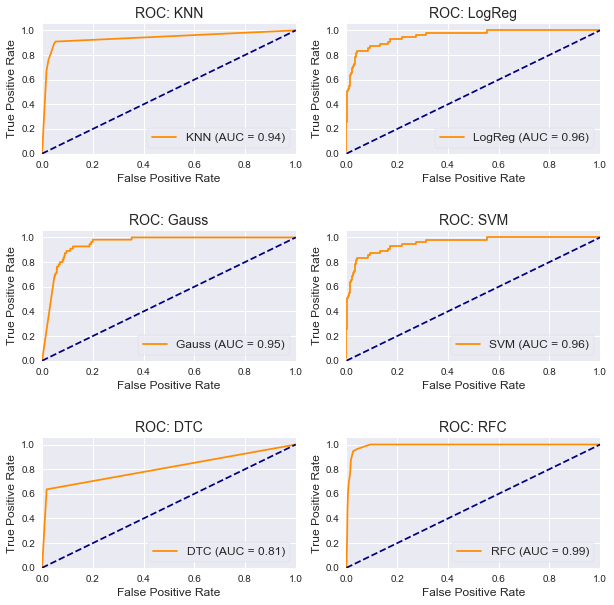

In [133]:
scores = {}
holdoutscores = {}
holdoutpreds = {}
fpr = {}
tpr = {}
roc_auc = {}

for clf, clfname in zip(classifiers,classifiernames):
# Fit Model to Training Data
    model = clf.fit(X_train,y_train)
    
# Predictions from Test 
    y_pred = model.predict(X_test) 
    
# Calculate and Store Metrics for Train/Test
    acc = metrics.accuracy_score(y_test,y_pred)
    prec = metrics.precision_score(y_test,y_pred)
    rec = metrics.recall_score(y_test,y_pred)
    F1 = metrics.f1_score(y_test,y_pred)
    scores[clfname] = [acc,prec,rec,F1]
    
# Calculate Test Score for ROC/AUC
    try:
        y_score = model.decision_function(X_test)
    except AttributeError:
        y_score = model.predict_proba(X_test)[:,1:]
    
    fpr[clfname],tpr[clfname], _ = metrics.roc_curve(y_test,y_score)
    roc_auc[clfname] = metrics.auc(fpr[clfname],tpr[clfname])

#################
## HOLDOUT SET ##
#################

# Predictions from Holdout Set
    y_pred2 = model.predict(holdout_X)
    
# Create Holdout Dataframe
    holdout = holdout_text.copy()
    
# Calculate and Store Metrics for Holdout Set
    acc2 = metrics.accuracy_score(holdout_y,y_pred2)
    prec2 = metrics.precision_score(holdout_y,y_pred2)
    rec2 = metrics.recall_score(holdout_y,y_pred2)
    F12 = metrics.f1_score(holdout_y,y_pred2)   
    holdoutscores[clfname] = [acc2,prec2,rec2,F12]

# Calculate Probabilities for Each Holdout Prediction
    holdout['Prediction'] = y_pred2
    
    try:
        y_prob = model.predict_proba(holdout_X)
        holdout['Probability'] = y_prob[:,1]
    except AttributeError:
        y_prob = np.nan
        holdout['Probability'] = y_prob   
    
# Save Probabilities and Predictions to Dictionary
    holdoutpreds[clfname] = holdout
    
# ## Classification Reports
#     print(clfname,'\nTrain/Test Classification Report:\n',
#     '---------------------------------------------------\n',
#     metrics.classification_report(y_test, y_pred))   

#     print(clfname,'\nHoldout Classification Report:\n',
#     '---------------------------------------------------\n',
#     metrics.classification_report(holdout_y, y_pred2))
    
summary = pd.DataFrame(scores)
summary.insert(0,'Metric',['Accuracy','Precision','Recall','F1 Score'])

holdout_summary = pd.DataFrame(holdoutscores)
holdout_summary.insert(0,'Metric',['Accuracy','Precision','Recall','F1 Score'])

print('Train/Test Classification Metrics\n',
      '---------------------------------------------------')
print(summary.round(2),
      '\n---------------------------------------------------\n')
print('Holdout Classification Metrics\n',
      '---------------------------------------------------')
print(holdout_summary.round(2),
      '\n---------------------------------------------------\n')

for clfname, preds in holdoutpreds.items():
    print(clfname,
          'Predictions:\n',
          '------------------------------------------------------------------------\n',
          preds,'\n')

#ROC_AUC
plt.figure(figsize=(10,10))
for n,c in enumerate(classifiernames):
    plt.subplot(3,2,n+1)
    plt.subplots_adjust(hspace=0.6)
    plt.title('ROC: '+c,fontsize=14)
    
    plt.plot(fpr[c],tpr[c],color='darkorange',label = c+' (AUC = %0.2f)' %roc_auc[c])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.legend(loc='lower right',frameon=True,fontsize=12)

# #4 Upsampled Cross-Validation

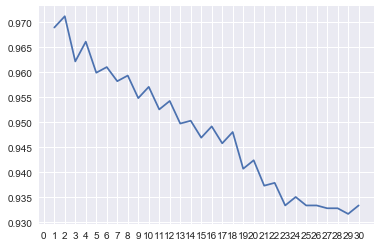

Best K: 2


In [134]:
# K-Nearest Neighbors
knn_scores = {}
for k in range(1,31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    knn_scores[k] = metrics.accuracy_score(y_test, y_pred)
    
plt.plot(list(knn_scores.keys()),list(knn_scores.values()))
plt.xticks(np.arange(0, 31, 1.0))
plt.show()

highest_k = max(knn_scores, key=knn_scores.get)
print('Best K:', highest_k)

In [135]:
from sklearn.cross_validation import cross_val_score

knn_score = np.mean(cross_val_score(knn,X,y,cv=5,scoring='accuracy',n_jobs=-1))
logreg_score = np.mean(cross_val_score(logreg,X,y,cv=5,scoring='accuracy',n_jobs=-1))
gauss_score = np.mean(cross_val_score(gauss,X,y,cv=5,scoring='accuracy',n_jobs=-1))
svc_score = np.mean(cross_val_score(svc,X,y,cv=5,scoring='accuracy',n_jobs=-1))
# svc_score = np.mean(cross_val_score(lsvc,X,y,cv=5,scoring='accuracy',n_jobs=-1))
dtc_score = np.mean(cross_val_score(dtc,X,y,cv=5,scoring='accuracy',n_jobs=-1))
rfc_score = np.mean(cross_val_score(rfc,X,y,cv=5,scoring='accuracy',n_jobs=-1))

results = pd.DataFrame([knn_score,logreg_score,gauss_score,svc_score,dtc_score,rfc_score],columns=['Score'])
results['Classifier'] = ['KNN','LogReg','Gauss','SVM','DTC','RFC']
results['vs. Baseline'] = results.Score - noHOF_pred
results = results[['Classifier','Score','vs. Baseline']]
results

,Classifier,Score,vs. Baseline
0,KNN,0.962258,-0.006900
1,LogReg,0.584944,-0.384213
2,Gauss,0.877465,-0.091693
3,SVM,0.584944,-0.384213
4,DTC,0.986294,0.017136
5,RFC,0.990999,0.021841


## #5 Upsampled With Feature Selection

In [136]:
from sklearn import feature_selection

In [137]:
## Define classifiers 
# knn = KNeighborsClassifier(n_neighbors=highest_k)
logreg = LogisticRegression(n_jobs=-1)
# gauss = GaussianNB()
# svc = SVC(probability=True)#,kernel='linear')
# lsvc = LinearSVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier(n_jobs=-1)

classifiers = [logreg,dtc,rfc]
classifiernames = ['LogReg','DTC','RFC']

Train/Test Classification Metrics
 ---------------------------------------------------
      Metric   DTC  LogReg   RFC
0   Accuracy  0.98    0.97  0.98
1  Precision  0.59    0.54  0.61
2     Recall  0.82    0.67  0.76
3   F1 Score  0.69    0.60  0.68 
---------------------------------------------------

Holdout Classification Metrics
 ---------------------------------------------------
      Metric   DTC  LogReg  RFC
0   Accuracy  0.05     1.0  0.0
1  Precision  1.00     1.0  0.0
2     Recall  0.05     1.0  0.0
3   F1 Score  0.09     1.0  0.0 
---------------------------------------------------

LogReg Predictions:
------------------------------------------------------------------------
                    name shoot birthCountry  Prediction  Probability
116       Teemu Selanne     R      Finland           1     0.759515
202     Dave Andreychuk     R       Canada           1     0.674092
468           Rob Blake     R       Canada           1     0.668171
2188        Paul Kariya     L 

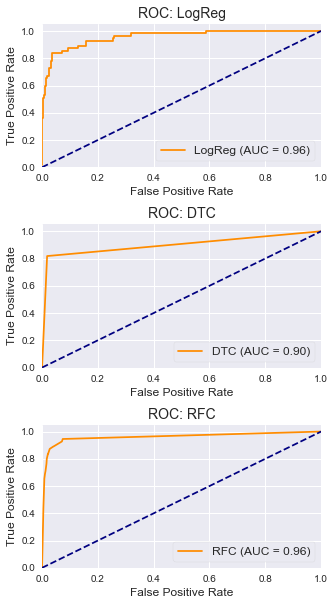

In [139]:
scores = {}
holdoutscores = {}
holdoutpreds = {}

fpr = {}
tpr = {}
roc_auc = {}

clf_x ={}

for clf,clfname in zip(classifiers,classifiernames):
    fs = feature_selection.SelectFromModel(clf,threshold='mean')
    X_train_new = pd.DataFrame(fs.fit_transform(X_train,y_train),columns = X.columns[fs.get_support()])
    X_test_new = pd.DataFrame(fs.transform(X_test),columns = X.columns[fs.get_support()])
    new_X = pd.concat([X_train_new,X_test_new],axis=0)
    X_holdout_new = pd.DataFrame(fs.transform(holdout_X),columns = X.columns[fs.get_support()])
    
    clf_x[clfname] = [X_train_new,X_test_new,X_holdout_new,new_X]
    
    # Test Set - Prediction Score
    clf.fit(X_train_new,y_train)
    y_pred = clf.predict(X_test_new)
    
#     print(clfname,'\nTrain/Test Classification Report:\n',
#           '---------------------------------------------------\n',
#           metrics.classification_report(y_test, y_pred))   
    
    try:
        y_score = clf.decision_function(X_test_new)
    except AttributeError:
        y_score = clf.predict_proba(X_test_new)[:,1:]
    
    acc = metrics.accuracy_score(y_test,y_pred)
    prec = metrics.precision_score(y_test,y_pred)
    rec = metrics.recall_score(y_test,y_pred)
    F1 = metrics.f1_score(y_test,y_pred)
    
    scores[clfname] = [acc,prec,rec,F1]
    
    # Holdout Predictions
    y_pred2 = clf.predict(X_holdout_new)
    try:
        y_prob2 = clf.predict_proba(X_holdout_new)
    except AttributeError:
        y_prob2 = 'N/A'
    
#     print(clfname,'\nHoldout Classification Report:\n',
#         '---------------------------------------------------\n',
#           metrics.classification_report(holdout_y, y_pred2))
    
    acc2 = metrics.accuracy_score(holdout_y,y_pred2)
    prec2 = metrics.precision_score(holdout_y,y_pred2)
    rec2 = metrics.recall_score(holdout_y,y_pred2)
    F12 = metrics.f1_score(holdout_y,y_pred2)
    
    holdoutscores[clfname] = [acc2,prec2,rec2,F12]
    
    holdout = holdout_text.copy()
    
    # Holdout Prbabilities
    holdout['Prediction'] = y_pred2
    try:
        holdout['Probability'] = y_prob2[:,1]
    except TypeError:
        holdout['Probability'] = y_prob2
    holdoutpreds[clfname] = holdout
    
    fpr[clfname],tpr[clfname], _ = metrics.roc_curve(y_test,y_score)
    roc_auc[clfname] = metrics.auc(fpr[clfname],tpr[clfname])
    
summary = pd.DataFrame(scores)
summary.insert(0,'Metric',['Accuracy','Precision','Recall','F1 Score'])

holdout_summary = pd.DataFrame(holdoutscores)
holdout_summary.insert(0,'Metric',['Accuracy','Precision','Recall','F1 Score'])

print('Train/Test Classification Metrics\n','---------------------------------------------------')
print(summary.round(2),'\n---------------------------------------------------\n')
print('Holdout Classification Metrics\n','---------------------------------------------------')
print(holdout_summary.round(2),'\n---------------------------------------------------\n')

for clfname, preds in holdoutpreds.items():
    print(clfname,
          'Predictions:\n------------------------------------------------------------------------\n',
          preds,'\n')
    
#ROC_AUC
plt.figure(figsize=(5,10))
for n,c in enumerate(classifiernames):
    plt.subplot(3,1,n+1)
    plt.subplots_adjust(hspace=0.4)
    plt.title('ROC: '+c,fontsize=14)
    
    plt.plot(fpr[c],tpr[c],color='darkorange',label = c+' (AUC = %0.2f)' %roc_auc[c])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.legend(loc='lower right',frameon=True,fontsize=12)

### Feature Selection Cross-Validation

In [141]:
logreg_score = np.mean(cross_val_score(logreg,clf_x['LogReg'][3],y,cv=5,scoring='accuracy',n_jobs=-1))
# svc_score = np.mean(cross_val_score(svc,clf_x['SVM'][3],y,cv=5,scoring='accuracy',n_jobs=-1))
# lsvc_score = np.mean(cross_val_score(lsvc,clf_x['LSVM'][3],y,cv=5,scoring='accuracy',n_jobs=-1))
dtc_score = np.mean(cross_val_score(dtc,clf_x['DTC'][3],y,cv=5,scoring='accuracy',n_jobs=-1))
rfc_score = np.mean(cross_val_score(rfc,clf_x['RFC'][3],y,cv=5,scoring='accuracy',n_jobs=-1))

results = pd.DataFrame([logreg_score,dtc_score,rfc_score],columns=['Score'])
results['Classifier'] = ['LogReg','DTC','RFC']
results['vs. Baseline'] = results.Score - noHOF_pred
results = results[['Classifier','Score','vs. Baseline']]
results

,Classifier,Score,vs. Baseline
0,LogReg,0.584944,-0.384213
1,DTC,0.982919,0.013761
2,RFC,0.990692,0.021534


## GridSearchCV on LogReg

In [142]:
from sklearn.model_selection import ParameterGrid, GridSearchCV

## Define classifiers 
logreg = LogisticRegression()
# svc = SVC(probability=True,kernel='linear')

classifiers = [logreg]#,svc]
classifiernames = ['LogReg']#,'SVC']

In [143]:
for clf,clfname in zip(classifiers,classifiernames):
    print(clfname,clf.get_params(),'\n')  

LogReg {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 



LogReg 
Train/Test Classification Report:
 ---------------------------------------------------
              precision    recall  f1-score   support

          0       1.00      0.95      0.97      1716
          1       0.34      0.85      0.49        55

avg / total       0.97      0.94      0.96      1771

LogReg 
Holdout Classification Report:
 ---------------------------------------------------
              precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.90      0.95        21

avg / total       1.00      0.90      0.95        21

Train/Test Classification Metrics
 ---------------------------------------------------
      Metric  LogReg
0   Accuracy    0.94
1  Precision    0.34
2     Recall    0.85
3   F1 Score    0.49 
---------------------------------------------------

Holdout Classification Metrics
 ---------------------------------------------------
      Metric  LogReg
0   Accuracy    0.90
1  Precis

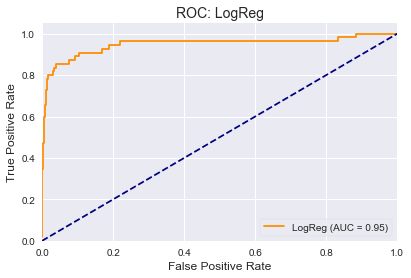

In [158]:
np.seterr(over='warn', under=None, invalid=None)

scores = {}
holdoutscores = {}
holdoutpreds = {}
fpr = {}
tpr = {}
roc_auc = {}

clf_x2 = {}

for clf,clfname in zip(classifiers,classifiernames):
# Bring in Models from Feature Selection   
    X_train_new = clf_x[clfname][0] 
    X_test_new = clf_x[clfname][1]
    X_holdout_new = clf_x[clfname][2]
    
# Test Set - Prediction Score
    if clfname == 'LogReg':
        params = {'C': np.array([1,10,100,1000,10000,100000]),
                'penalty':['l1','l2'],
                'dual' : [True,False],
                'fit_intercept':[True,False],
                 'n_jobs':[-1]}
#     if clfname == 'SVC':
#         params = {'C': [0.001, 0.01, 0.1, 1, 10], 
#                   'probability':True,
#                   'kernel':'linear',
#                   'gamma': [0.001, 0.01, 0.1, 1],
#                   'n_jobs':[-1]
#                  }
    
    model = GridSearchCV(clf, params,cv=5, scoring='f1',error_score=0,n_jobs=-1)
    
# Fit Model to Training Data
    model.fit(X_train_new, y_train)
    
# Store Best Params
    if clfname == 'LogReg':
        logreg_params = model.best_params_
        logreg_cols = X_train_new.columns
    if clfname == 'RFC':
        rfc_params = model.best_params_
        rfc_cols = X_train_new.columns
        
# Predictions from Test 
    y_pred = model.predict(X_test_new) 
    
# Calculate and Store Metrics for Train/Test
    acc = metrics.accuracy_score(y_test,y_pred)
    prec = metrics.precision_score(y_test,y_pred)
    rec = metrics.recall_score(y_test,y_pred)
    F1 = metrics.f1_score(y_test,y_pred)
    scores[clfname] = [acc,prec,rec,F1]
    
# Calculate Test Score for ROC/AUC
    try:
        y_score = model.decision_function(X_test_new)
    except AttributeError:
        y_score = model.predict_proba(X_test_new)[:,1:]
    
    fpr[clfname],tpr[clfname], _ = metrics.roc_curve(y_test,y_score)
    roc_auc[clfname] = metrics.auc(fpr[clfname],tpr[clfname])

#################
## HOLDOUT SET ##
#################

# Predictions from Holdout Set
    y_pred2 = model.predict(X_holdout_new)
    
# Create Holdout Dataframe
    holdout = holdout_text.copy()
    
# Calculate and Store Metrics for Holdout Set
    acc2 = metrics.accuracy_score(holdout_y,y_pred2)
    prec2 = metrics.precision_score(holdout_y,y_pred2)
    rec2 = metrics.recall_score(holdout_y,y_pred2)
    F12 = metrics.f1_score(holdout_y,y_pred2)   
    holdoutscores[clfname] = [acc2,prec2,rec2,F12]

# Calculate Probabilities for Each Holdout Prediction
    holdout['Prediction'] = y_pred2
    
    try:
        y_prob = model.predict_proba(X_holdout_new)
        holdout['Probability'] = y_prob[:,1]
    except AttributeError:
        y_prob = np.nan
        holdout['Probability'] = y_prob   
    
# Save Probabilities and Predictions to Dictionary
    holdoutpreds[clfname] = holdout
    
## Classification Reports
    print(clfname,'\nTrain/Test Classification Report:\n',
    '---------------------------------------------------\n',
    metrics.classification_report(y_test, y_pred))   

    print(clfname,'\nHoldout Classification Report:\n',
    '---------------------------------------------------\n',
    metrics.classification_report(holdout_y, y_pred2))
    
summary = pd.DataFrame(scores)
summary.insert(0,'Metric',['Accuracy','Precision','Recall','F1 Score'])

holdout_summary = pd.DataFrame(holdoutscores)
holdout_summary.insert(0,'Metric',['Accuracy','Precision','Recall','F1 Score'])

print('Train/Test Classification Metrics\n',
      '---------------------------------------------------')
print(summary.round(2),
      '\n---------------------------------------------------\n')
print('Holdout Classification Metrics\n',
      '---------------------------------------------------')
print(holdout_summary.round(2),
      '\n---------------------------------------------------\n')

for clfname, preds in holdoutpreds.items():
    print(clfname,
          'Predictions:\n',
          '------------------------------------------------------------------------\n',
          preds,'\n')

#ROC_AUC
plt.figure(figsize=(14,4))
for n,c in enumerate(classifiernames):
    plt.subplot(1,2,n+1)
    plt.subplots_adjust(hspace=0.4)
    plt.title('ROC: '+c,fontsize=14)
    
    plt.plot(fpr[c],tpr[c],color='darkorange',label = c+' (AUC = %0.2f)' %roc_auc[c])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.legend(loc='lower right',frameon=True)

### Final Cross-Validation

In [159]:
logreg_score = np.mean(cross_val_score(logreg,clf_x['LogReg'][3],y,cv=5,scoring='accuracy',n_jobs=-1))

results = pd.DataFrame([logreg_score],columns=['Score'])
results['Classifier'] = ['LogReg']
results['vs. Baseline'] = results.Score - noHOF_pred
results = results[['Classifier','Score','vs. Baseline']]
results

,Classifier,Score,vs. Baseline
0,LogReg,0.507315,-0.461843


## Logistic Regression Feature Importances

In [162]:
c = logreg_params.get('C')
d = logreg_params.get('dual')
f = logreg_params.get('fit_intercept')

X_train_new = clf_x['LogReg'][0] 

logreg = LogisticRegression(C=c,dual=d,fit_intercept=f)
logreg.fit(X_train_new, y_train);

logreg_importance = pd.DataFrame(logreg.coef_,columns=X_train_new.columns)
logreg_importance = logreg_importance.iloc[0].reset_index()
logreg_importance.columns = ['Feature','Importance']
logreg_importance.Importance = logreg_importance.Importance
logreg_importance = logreg_importance.sort_values('Importance',ascending=False)
logreg_importance.head(10)

,Feature,Importance
9,award_count,247.437406
11,won_cup,106.612420
0,G,77.251502
2,Pts,64.456789
1,A,56.357116
4,PPG,49.198618
8,GTG,40.433101
10,series_wins,37.344989
3,plus_min,37.210725
7,GWG,36.213826


In [161]:
X_train_new = clf_x['RFC'][0] 
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train_new, y_train)
labels = X_train_new.columns
rfc_importance = pd.DataFrame(rfc.feature_importances_)
rfc_importance.columns = ['Importance']
rfc_importance.insert(0,'Feature',labels)
rfc_importance = rfc_importance.sort_values('Importance',ascending=False)
rfc_importance

,Feature,Importance
4,A_rank,0.206508
5,Pts_rank,0.154910
2,award_count,0.137734
7,A_rank_T,0.137527
8,Pts_rank_T,0.085877
0,birthYear,0.084320
9,LastYear,0.061244
3,won_cup,0.048853
1,Pts,0.046360
6,SOG_rank,0.036668
